# Estimation of flight delays

### Data exploration

#### Loading dataset

In [1]:
import pandas as pd

data = pd.read_csv('data/dataset_SCL.csv',parse_dates=['Fecha-I','Fecha-O'])


bStart, bEnd = ['\x1b[1;30m','\x1b[0m']
N = data.shape[0]
print('Size of the dataset '+bStart+'N:',N,bEnd)

print(bStart+'Features ('+str(data.shape[1])+'): '+bEnd+'\n\t -'+'\n\t -'.join(data.columns))

Size of the dataset N: 68206 
Features (18): 
	 -Fecha-I
	 -Vlo-I
	 -Ori-I
	 -Des-I
	 -Emp-I
	 -Fecha-O
	 -Vlo-O
	 -Ori-O
	 -Des-O
	 -Emp-O
	 -DIA
	 -MES
	 -AÑO
	 -DIANOM
	 -TIPOVUELO
	 -OPERA
	 -SIGLAORI
	 -SIGLADES


/home/cristobal/workspace/flight-delay/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
import numpy as np

compareData = ['Vlo', 'Ori', 'Des', 'Emp']

for comp in compareData:
    comparison = data[comp+'-I'] != data[comp+'-O']

    if comparison.any():
        print(comp+' differs '+bStart+str(sum(comparison))+bEnd+' times, at:')
        print(np.where(comparison))
    else:
        print(comp+' do not differ')

Vlo differs 1850 times, at:
(array([ 6018,  6020,  6022, ..., 65534, 65535, 68068]),)
Ori do not differ
Des differs 28 times, at:
(array([ 1397,  7290,  7520,  8456, 12787, 12823, 16169, 16937, 18293,
       20444, 24569, 25419, 25422, 25492, 33166, 37162, 38094, 38135,
       38136, 39265, 42112, 55144, 61463, 62651, 67599, 67600, 67601,
       67697]),)
Emp differs 18669 times, at:
(array([  345,   814,   815, ..., 67879, 67880, 67881]),)


#### Plotting data

Following plots show distributions of a subset of the data.

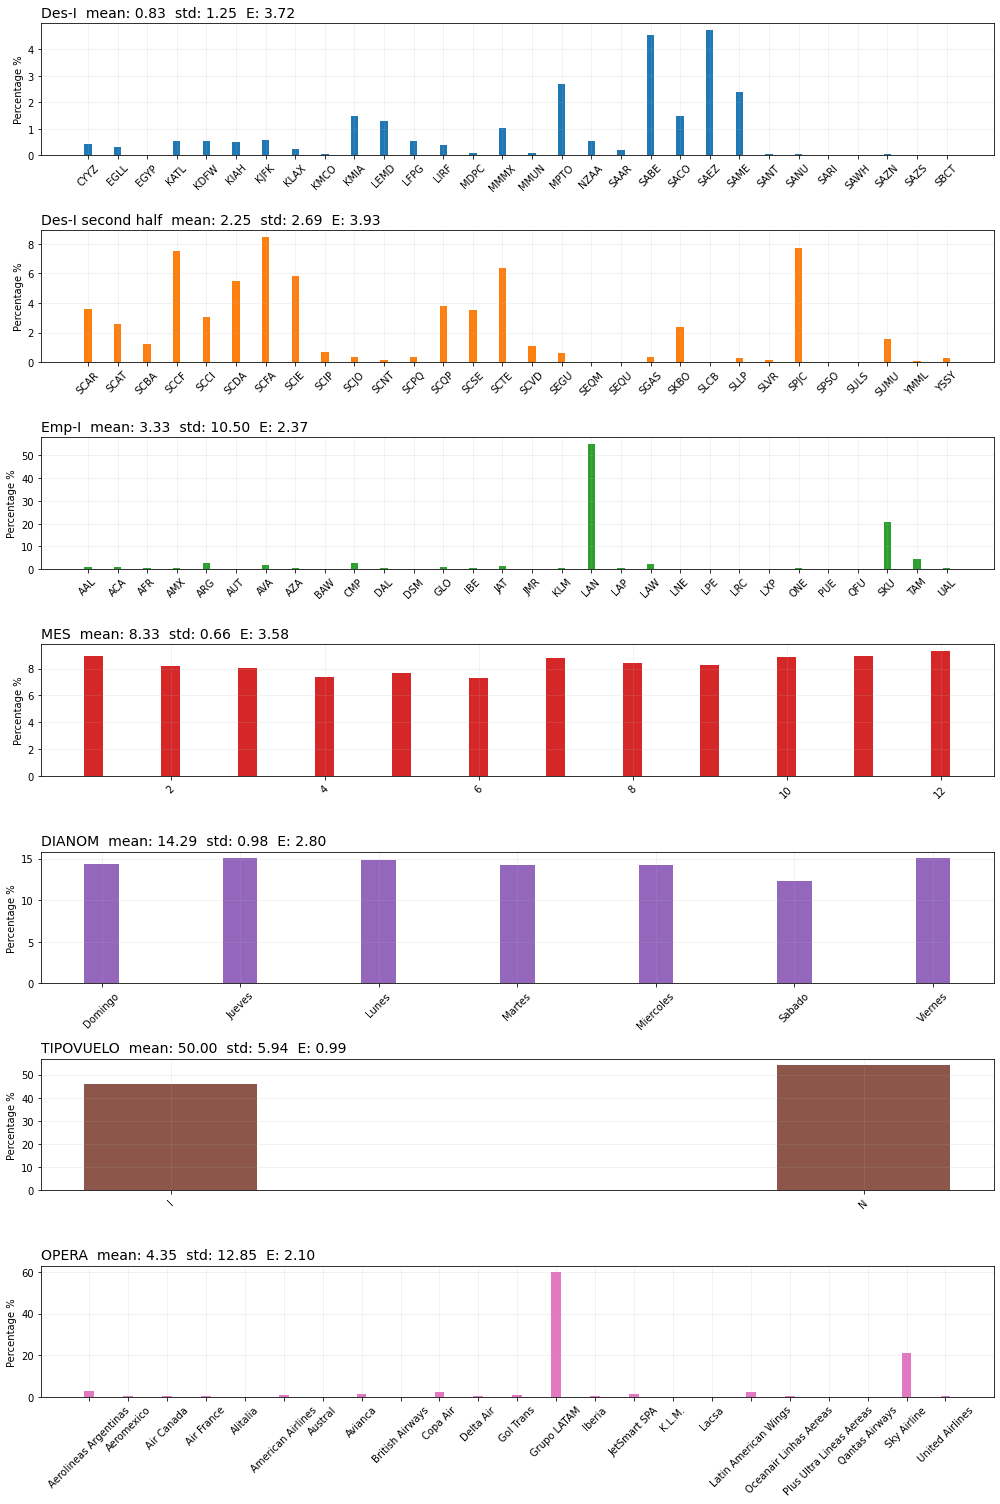

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

toShow = ['Des-I', 'last-Des-I', 'Emp-I', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA']
nPlots = len(toShow)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

total = data.shape[0]
usePercentage = True

for col,ax,color in zip(toShow,axs,colors):
    if 'last-' in col:
        col = col.replace('last-','')
        title = col + ' second half'
        vCounts = data[col].value_counts().sort_index()[-30:]
    else:
        title = col
        vCounts = data[col].value_counts().sort_index()[:30]
    cat = vCounts.index
    count = 100.0*vCounts.values/total if usePercentage else vCounts.values
    m,s = [np.mean(count),np.std(count,ddof=1)]
    E = entropy(vCounts.values/total, base=2)
    # sem = s/np.sqrt(total)
    title = title+'  mean: '+f'{m:.2f}'+'  std: '+f'{s:.2f}'+'  E: '+f'{E:.2f}'
    if len(cat)>30:
        cat = cat[:30]
        count = count[:30]
        title = 'TOP 30: '+title
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(title,fontsize=14,loc='left')
    ax.set_ylabel('Percentage %' if usePercentage else 'Counts #')
    ax.grid(alpha=0.2)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()

From the data, it can be extracted that:
  - Destinations are widely varied, being a potentially informative variable (it has the greatest entropy).
  - Managing companies show a spare distribution, LAN managed more than 50% of the flights. 
  - Data from MES, DIANOM, and TIPOVUELO have a more flat distributions, meaning that they can also be informative.

## Creating synthetic features

In [4]:
from datetime import date as dt

highSeasons = [[dt(2016,12,15),dt(2017,3,3)],
               [dt(2017,7,15),dt(2017,7,31)],
               [dt(2017,9,11),dt(2017,9,30)],
               [dt(2017,12,15),dt(2018,3,3)]]

newFeatures = {'temporada_alta': np.full((N,),False)}
for hS in highSeasons:
    fI = data['Fecha-I'].dt.date
    newFeatures['temporada_alta'] |= ((fI >= hS[0]) & (fI <= hS[1]))

newFeatures['dif_min'] = (data['Fecha-O']-data['Fecha-I'])/pd.Timedelta(minutes=1)
newFeatures['atraso_15'] = newFeatures['dif_min'] > 15

hours = data['Fecha-I'].dt.hour
newFeatures['periodo_dia'] = np.full((N,),'      ')
newFeatures['periodo_dia'][(hours >=5) & (hours < 12)] = 'mañana'
newFeatures['periodo_dia'][(hours >=12) & (hours < 19)] = 'tarde'
newFeatures['periodo_dia'][(hours >=19) | (hours < 5)] = 'noche'

newFeatures = pd.DataFrame.from_dict(newFeatures)
newFeatures['temporada_alta'] = newFeatures['temporada_alta'].astype(int)
newFeatures['atraso_15'] = newFeatures['atraso_15'].astype(int)
newFeatures['emp_diff'] = data['Emp-I']!=data['Emp-O']

data['atraso_15'] = newFeatures['atraso_15']
window = 5
for group, df in data.groupby('Emp-I'):
    acc_delay = df['atraso_15'].rolling(window).sum().fillna(0)
    newFeatures.loc[acc_delay.index, 'accum_delay'] = acc_delay

newFeatures.to_csv('synthetic_features.csv')

## Plotting delay distributions

Lets see the delay rate of a part of the set of features: 

Total delays (>= 15 min):  12614 


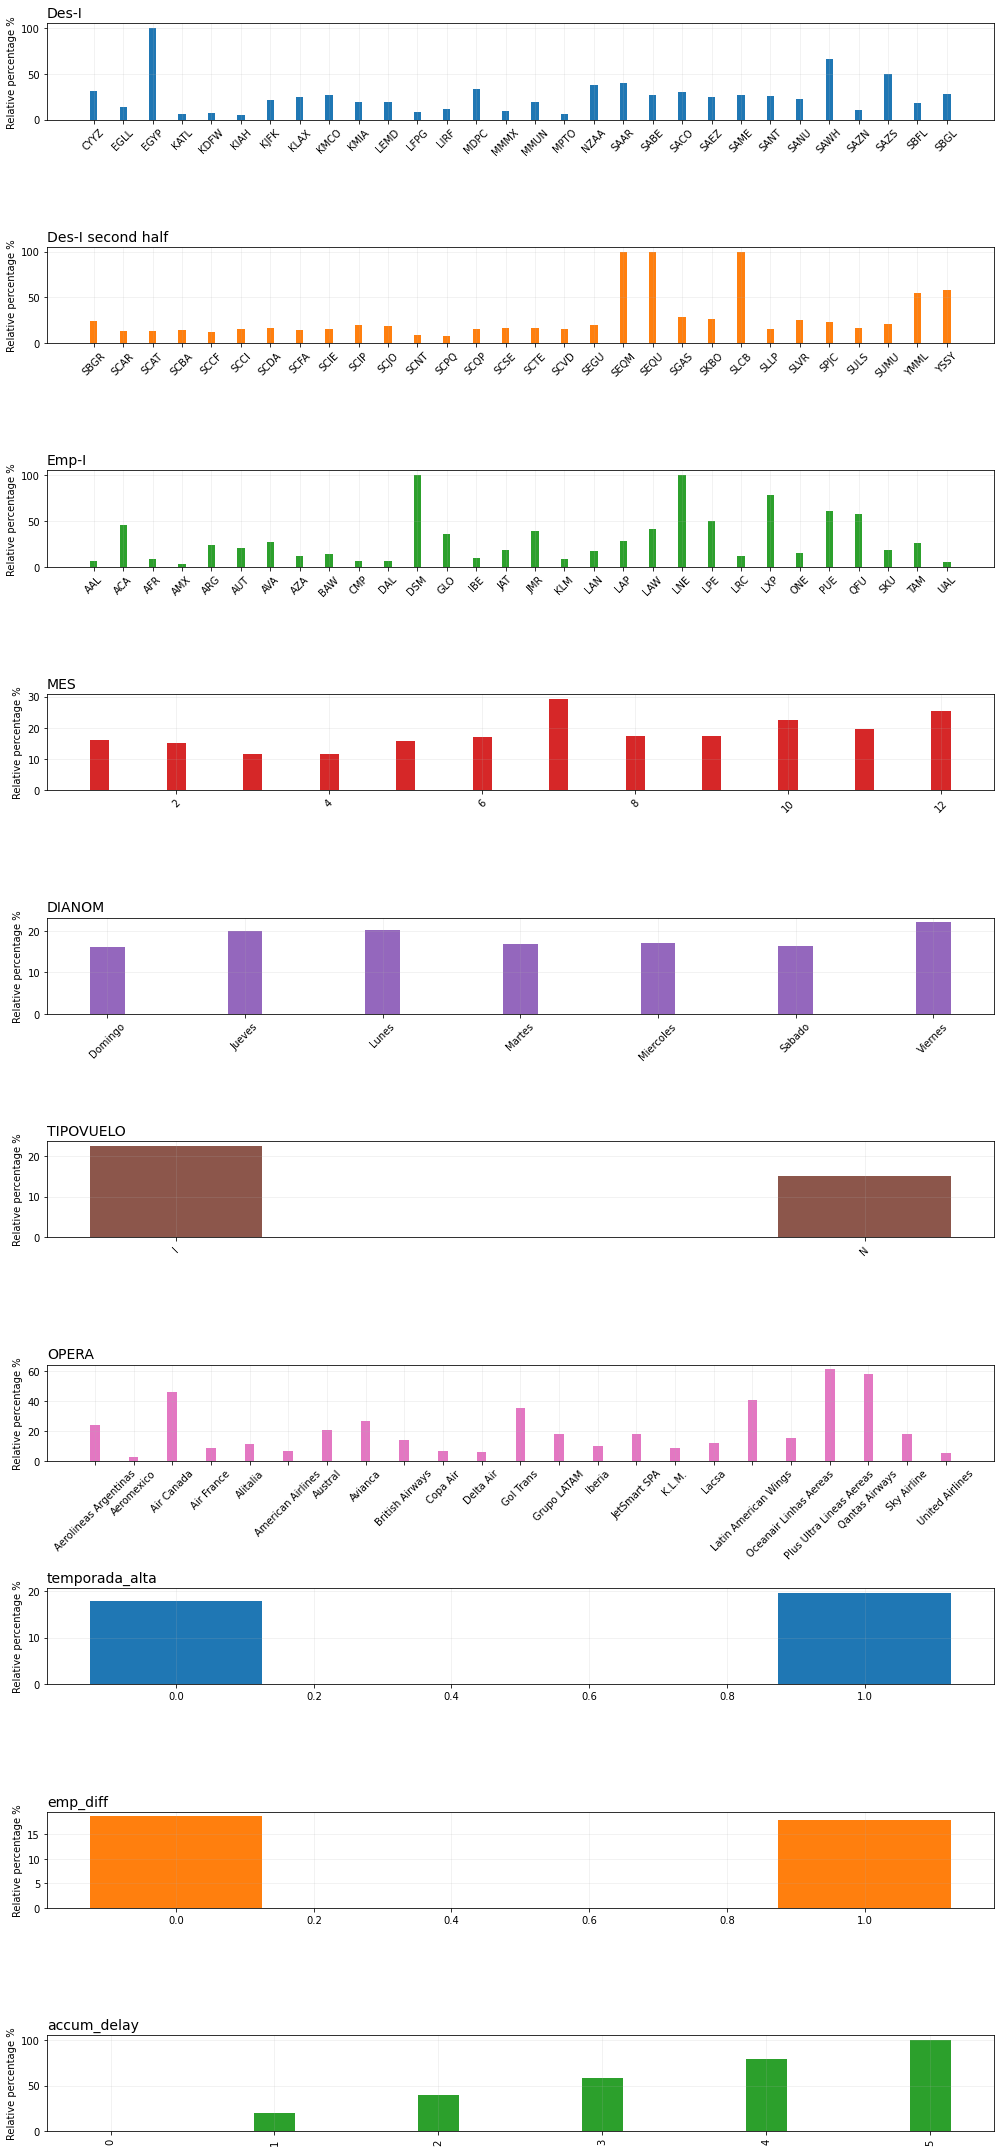

In [5]:
toCompare = {'data':      ['Des-I', 'last-Des-I', 'Emp-I', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA'], 
             'synthetic': ['temporada_alta', 'emp_diff', 'accum_delay']
            }

nPlots = len(toCompare['data'])+len(toCompare['synthetic'])
fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

usePercentage = True
total = sum(newFeatures['atraso_15'] > 0)
print('Total delays (>= 15 min):',bStart,total,bEnd)

for col,ax,color in zip(toCompare['data'],axs,colors):
    if 'last-' in col:
        col = col.replace('last-','')
        title = col + ' second half'
        vCounts = data[col][newFeatures['atraso_15'] > 0].value_counts().sort_index()[-30:]
    else:
        title = col
        vCounts = data[col][newFeatures['atraso_15'] > 0].value_counts().sort_index()[:30]
    cat = vCounts.index
    count = [100.0*vCounts.values[i]/sum(data[col]==vCounts.index[i]) for i in range(len(vCounts.values))]
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(title,fontsize=14,loc='left')
    ax.set_ylabel('Relative percentage %' if usePercentage else 'Counts #')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.grid(alpha=0.2)

for col,ax,color in zip(toCompare['synthetic'],axs[-len(toCompare['synthetic']):],colors):
    vCounts = newFeatures[col][newFeatures['atraso_15'] > 0].value_counts()
    cat = vCounts.index
    total = newFeatures[col]
    count = [100.0*vCounts.values[i]/sum(newFeatures[col]==vCounts.index[i]) for i in range(len(vCounts.values))]
    if len(cat)>30:
        cat = cat[:30]
        count = count[:30]
        title = 'TOP 30: '+title
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(col,fontsize=14,loc='left')
    ax.set_ylabel('Relative percentage %' if usePercentage else 'Counts #')
    plt.xticks(rotation=90)
    ax.grid(alpha=0.2)
plt.tight_layout()

The rate of delay over each feature shows that:
  - Some destinations are highly determinant as their relative rate of delay is 100% (all flights to those destinations were delay).
  - The same happend with managing companies.
  
 This may imply that those variables can be highly informative, but it is important to know if those destinations and companies, the ones with expected delays, have a relative high use (with respect to the others). If they are not common destinations nor used companies, then those features wont be as informative as expected.
 
The following plots show their delay rate wheighted by their relative use.

Total delays (>= 15 min):  12614 


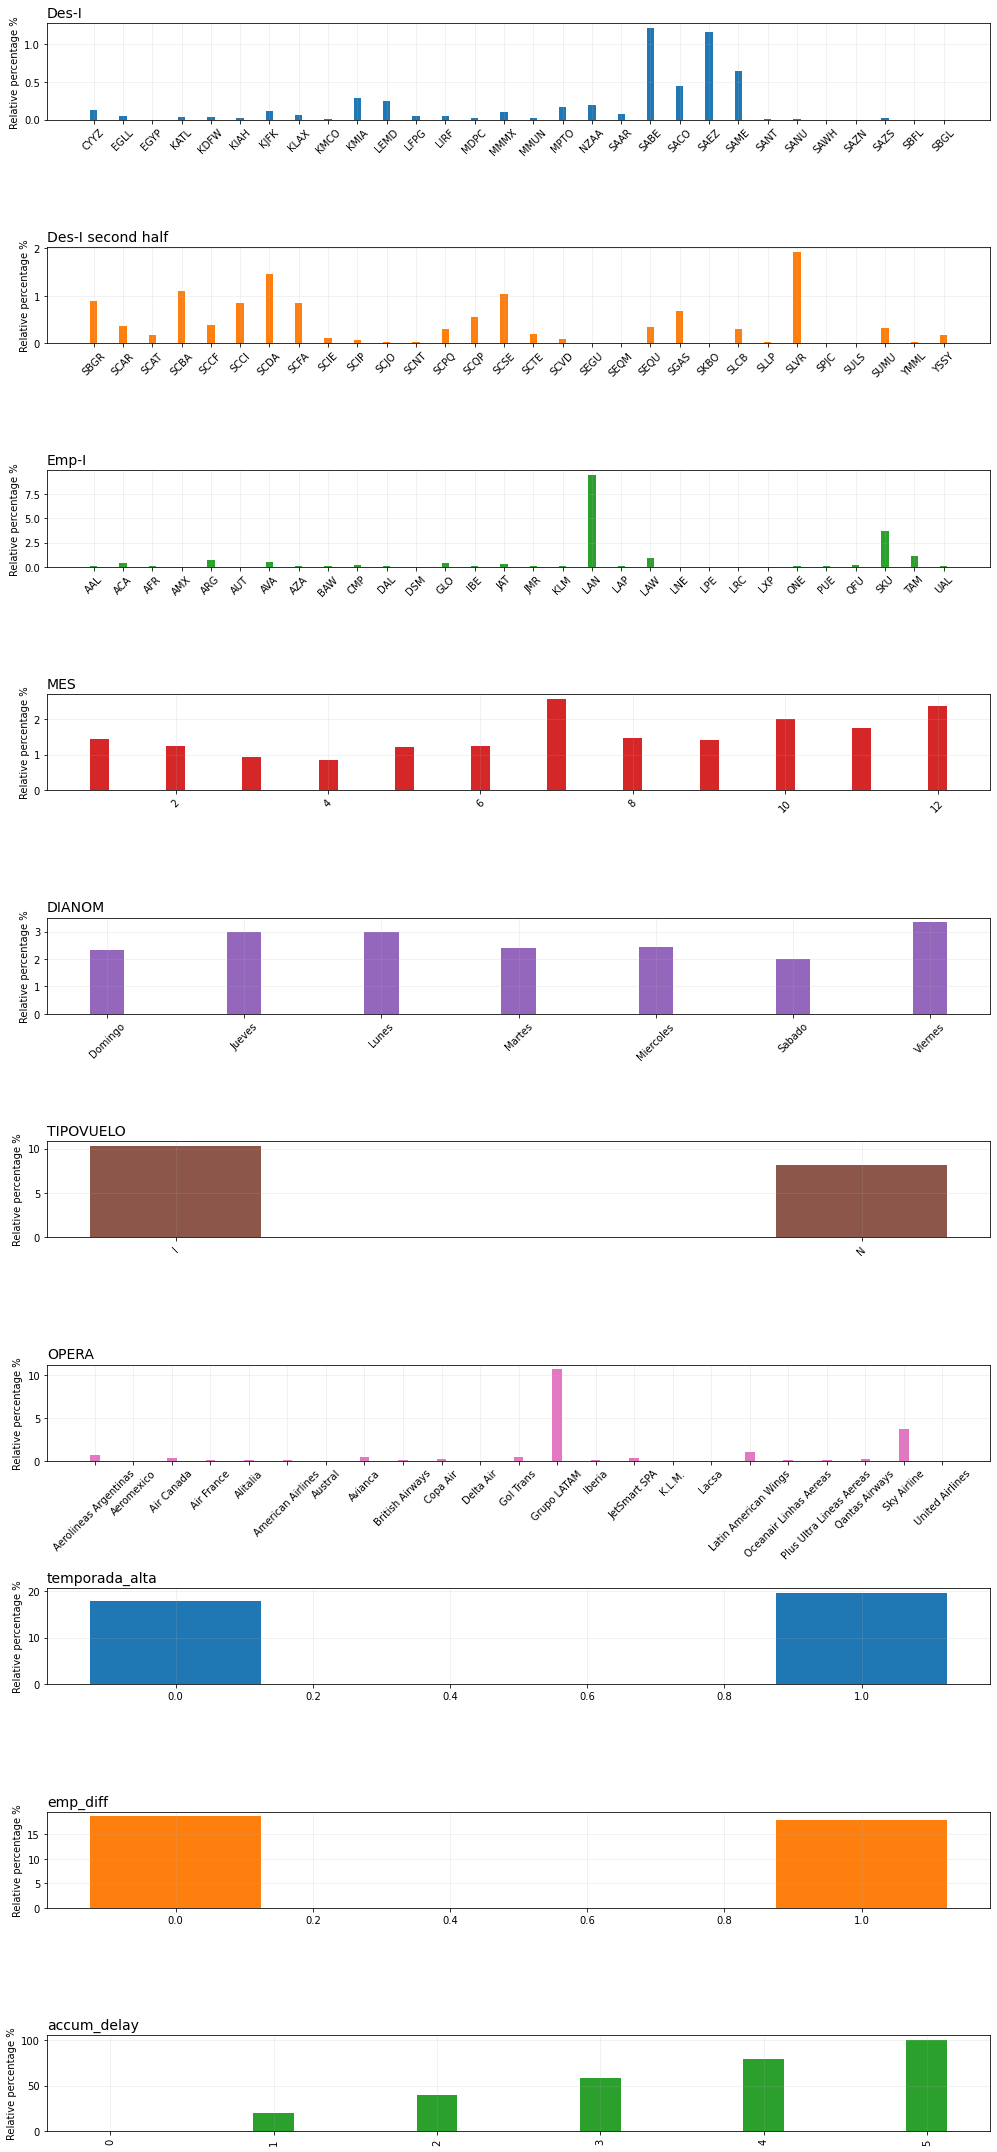

In [6]:
toCompare = {'data':      ['Des-I', 'last-Des-I', 'Emp-I', 'MES', 'DIANOM', 'TIPOVUELO', 'OPERA'], 
             'synthetic': ['temporada_alta', 'emp_diff', 'accum_delay']
            }

nPlots = len(toCompare['data'])+len(toCompare['synthetic'])
fig, axs = plt.subplots(nPlots,1,figsize=(14,3*nPlots))

usePercentage = True
total = sum(newFeatures['atraso_15'] > 0)
print('Total delays (>= 15 min):',bStart,total,bEnd)

for col,ax,color in zip(toCompare['data'],axs,colors):
    if 'last-' in col:
        col = col.replace('last-','')
        title = col + ' second half'
        vCounts = data[col][newFeatures['atraso_15'] > 0].value_counts().sort_index()[-30:]
        catCount = data[col].value_counts().sort_index()[-30:]
    else:
        title = col
        vCounts = data[col][newFeatures['atraso_15'] > 0].value_counts().sort_index()[:30]
        catCount = data[col].value_counts().sort_index()[:30]
    cat = vCounts.index
    count = [(catCount.values[i]/N)*100.0*vCounts.values[i]/sum(data[col]==vCounts.index[i]) for i in range(len(vCounts.values))]
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(title,fontsize=14,loc='left')
    ax.set_ylabel('Relative percentage %' if usePercentage else 'Counts #')
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.grid(alpha=0.2)

for col,ax,color in zip(toCompare['synthetic'],axs[-len(toCompare['synthetic']):],colors):
    vCounts = newFeatures[col][newFeatures['atraso_15'] > 0].value_counts()
    cat = vCounts.index
    total = newFeatures[col]
    count = [100.0*vCounts.values[i]/sum(newFeatures[col]==vCounts.index[i]) for i in range(len(vCounts.values))]
    if len(cat)>30:
        cat = cat[:30]
        count = count[:30]
        title = 'TOP 30: '+title
    ax.bar(cat, count, width=0.25, facecolor=color)
    ax.set_title(col,fontsize=14,loc='left')
    ax.set_ylabel('Relative percentage %' if usePercentage else 'Counts #')
    plt.xticks(rotation=90)
    ax.grid(alpha=0.2)
plt.tight_layout()

The relative use of the most certainly delayed companies and destinations highly reduced the impact of those variables.

Then, it is expected that the combination of the relevant variables (destination, company).

### Feature selection and data pre-processing

In [11]:
dataFeatures = ['MES','DIANOM','TIPOVUELO'] # Also 'OPERA' and 'Des-I', which are added below
fromNewFeatures = ['temporada_alta', 'periodo_dia', 'emp_diff', 'accum_delay']
categories = ['DIANOM','TIPOVUELO','periodo_dia']

features = pd.concat([ newFeatures[fromNewFeatures].reset_index(drop=True),
                       data[dataFeatures].reset_index(drop=True)
                       ],
                       axis=1,
                       ignore_index=True)
concatCol = [ list(newFeatures[fromNewFeatures].columns),
              list(data[dataFeatures].columns)]
    
flatten = lambda nested_lists: [item for sublist in nested_lists for item in sublist]

features.columns = flatten(concatCol)

for col in categories:
    features[col] = features[col].factorize()[0]

operatorClassification = [{'operators': ['Grupo LATAM'],'value': 5},
                          {'operators': ['Sky Airline'],'value': 2},
                          {'operators': ['Aerolineas Argentinas', 'Avianca', 'Copa Air', 'Gol Trans', 'JetSmart SPA','Latin American Wings'],'value': 1},]

def opClass(val, operatorClass=operatorClassification):
    for opClass in operatorClass:
        if val in opClass['operators']:
            return opClass['value']
    return 0

features['OPERA_CLUSTER'] = data.apply(lambda x : opClass(x['OPERA']), axis=1)

vCounts = data['Des-I'][newFeatures['atraso_15'] > 0].value_counts().sort_index()
cat = vCounts.index
values = [(100.0/20.0)*vCounts.values[i]/sum(data['Des-I']==vCounts.index[i]) for i in range(len(vCounts.values))]

def desClass(val,cat=cat,values=values):
    wh = np.where(cat==val)[0]
    if wh.size > 0:
        return np.round(values[wh[0]])
    else: 
        return 0

features['Des-I_cluster'] = data.apply(lambda x : desClass(x['Des-I']), axis=1)

features.to_csv('features_used.csv')

outputs = ['dif_min','atraso_15']

#### Standardizing

In [12]:
doStandardize = False

if doStandardize:
    standardize = ['Des-I_cluster','OPERA_CLUSTER', 'MES', 'DIANOM', ]

    for col in features.columns:
        if col in standardize:
            features[col] = (features[col] - np.mean(features[col])) / np.std(features[col],ddof=1)

#### Chi2 score

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

for output in outputs:
    print('\nChi2 score related to',bStart,output,bEnd)
    X = features
    y = newFeatures[output]
    bestfeatures = SelectKBest(score_func=chi2, k='all')
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    print(featureScores.sort_values('Score', ascending=False))


Chi2 score related to  dif_min 
            Specs         Score
3     accum_delay  26469.751653
7   OPERA_CLUSTER   6587.568219
4             MES   1694.703482
6       TIPOVUELO   1635.442257
2        emp_diff    794.626514
8   Des-I_cluster    449.380851
1     periodo_dia    444.184025
5          DIANOM    414.924141
0  temporada_alta    163.204769

Chi2 score related to  atraso_15 
            Specs         Score
3     accum_delay  25008.721038
4             MES    889.595600
6       TIPOVUELO    289.677616
8   Des-I_cluster     90.750362
1     periodo_dia     69.302464
5          DIANOM     67.334374
7   OPERA_CLUSTER     28.241504
0  temporada_alta     19.763185
2        emp_diff      2.984210


The Chi2 results show a greater correlation from the added feature **'accum_delay'**, which contains the history of the last 5 flights for each flight operator. That feature is expected to be highly considered in the model.

That column captures temporal dynamics, which will then be given directly to the model (through this input). This helps to avoid using LSTM to capture temporal correlations, avoiding its time consuming adjustments. Then, the approach for modelling will be the use of full connected layers.

Other interesting variables are:
  - OPERA_CLUSTER: cluster correlated with the time spent between 'Fecha-I' and 'Fecha-O'
  - MES, TIPOVUELO: in the top 5 correlated features with both delay's variables (dif_min and atraso_15), according to the Chi2 test.


In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

X = features
for output in outputs:
    print('\nTree classifier related to',bStart,output,bEnd)
    clf = DecisionTreeClassifier(criterion='entropy', random_state=0)
    scores = pd.DataFrame(cross_val_score(clf, X, newFeatures[output], cv=10))
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,scores],axis=1)
    featureScores.columns = ['Specs','Score']
    print(featureScores.sort_values('Score', ascending=False))


Tree classifier related to  dif_min 


/home/cristobal/workspace/flight-delay/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


            Specs     Score
0  temporada_alta  0.047794
9             NaN  0.031818
1     periodo_dia  0.029614
8   Des-I_cluster  0.017742
2        emp_diff  0.016713
7   OPERA_CLUSTER  0.012610
3     accum_delay  0.012315
4             MES  0.012315
6       TIPOVUELO  0.012170
5          DIANOM  0.009969

Tree classifier related to  atraso_15 
            Specs     Score
0  temporada_alta  0.822460
8   Des-I_cluster  0.667302
1     periodo_dia  0.657821
2        emp_diff  0.633485
6       TIPOVUELO  0.627566
3     accum_delay  0.617065
7   OPERA_CLUSTER  0.602786
9             NaN  0.572874
5          DIANOM  0.468406
4             MES  0.420613


### Modelling

Let's separate in train and test and construct a 4-hidden layers full connected NN.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input, metrics
from tensorflow.keras.backend import clear_session

xtr, xte, ytr, yte = train_test_split(features, newFeatures['atraso_15'], test_size=0.25, random_state=42)

model = Sequential()
model.add(Input(shape=(features.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

useMetrics = ['accuracy']
predictions = []
histories = []
for m in useMetrics:
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[m])
    model.summary()

    histories.append(model.fit(xtr,ytr,epochs=100,validation_data=(xte,yte)))#,verbose=True
    predictions.append(model.predict(features))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                320       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
Train on 51154 samples, validate on 17052 samples
Epoch 1/100
51154/51154 [==============================] - 3s 68us/sample - loss: 0.3526 - acc: 0.8371 - val_loss: 0.3252 - val_acc: 0.8415
Epoch 2/100
51154/51154 [==============================] - 4s 71us/sample - loss: 0.3248 - acc: 0.8420 - val_loss: 0.3208 - val_acc: 0.8431
Epoch 3/100
51154/51154 [===========================

Metrics:

	tp: 6589.00

	tn: 50656.00

	fp: 4936.00

	fn: 6025.00

	N: 68206.00

	accuracy: 0.84

	precision: 0.57

	recall: 0.52

	f1: 0.55


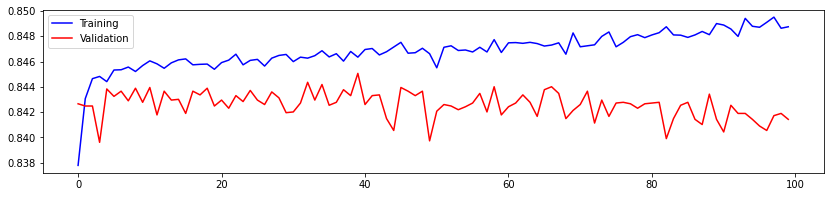

In [25]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize=(14,3))
xPos = range(len(histories[0].history['acc']))
plt.plot(xPos, histories[0].history['acc'], 'b', label='Training')
plt.plot(xPos, histories[0].history['val_acc'], 'r', label='Validation')
plt.legend()

prediction  = model.predict(features)
confusion   = confusion_matrix(newFeatures['atraso_15'],prediction>0.4)

metrics = {}
metrics['tp']             = confusion[1][1]
metrics['tn']             = confusion[0][0]
metrics['fp']             = confusion[0][1]
metrics['fn']             = confusion[1][0]
metrics['N' ]             = np.sum(confusion)

metrics['accuracy' ] = (metrics['tn']+metrics['tp']) / metrics['N']
metrics['precision'] = metrics['tp'] / (metrics['tp']+metrics['fp'])
metrics['recall'   ] = metrics['tp'] / (metrics['tp']+metrics['fn'])
metrics['f1'       ] = 2*metrics['precision']*metrics['recall']/(metrics['precision']+metrics['recall'])

print(bStart+'Metrics:'+bEnd)
for key in metrics.keys():
    print('\n\t'+bStart+key+bEnd+':',f'{metrics[key]:.2f}')

## Interpretation of the results 

The achieved accuracy reaches a 84% of right classifications.

##### About the metric
The metric used for training was accuracy, meaning that the focused was

The model as is, helps in advicing if a certain flight will be delayed or not.

## Other 